## NLP - Evaluation Notebook

* <b> We already train several models with cross validation and choose the best one (see NLP_training) </b>
* <b> Now we'll get the dev and held out target instances and add the short description (abstract) to each city </b>
* <b> We'll use this predictions as features for a regression notebook, for that we'll have to make OOB predictions to avoid overfitting. See [evaluation.ipynb](../evaluation.ipynb#LGBM-+-NPL-(from-notebook-nlp_evaluation)) </b>
* You can download the short description corpus from: <a href="http://dbpedia-generic.tib.eu/release/text/short-abstracts/2020.02.01/">here</a> (search the english one)

In [1]:
import pandas as pd
import numpy as np
from helper_functions import (discretize_target, get_short_descriptions, BIN_LABELS,
                              BIN_LABELS_TEXT, BINS, evaluate, words_analyser, get_upsampling, cross_validate)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from dbpedia_common import TARGET_DEV_CSV, TARGET_HELD_OUT_CSV
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

target_dev_df = pd.read_csv('../' + TARGET_DEV_CSV)
target_held_out_df = pd.read_csv('../' + TARGET_HELD_OUT_CSV)
short_abstracts = get_short_descriptions() # Parsing and loading descriptions (abstracts) of all cities

### Split the dataset in 8 bins penalizing more the errors in smaller cities

<Figure size 432x288 with 0 Axes>

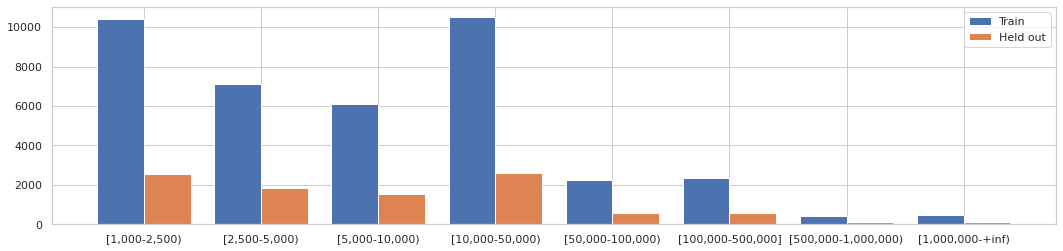

In [2]:
train_df = target_dev_df.copy()
train_df['target'] = discretize_target(train_df, BIN_LABELS, BINS)
train_df['description'] = train_df['subject'].map(short_abstracts)
# There are 9 instances with NO descriptions
train_df = train_df.drop(train_df[train_df.description.isnull()].index).reset_index(drop=True) 

test_df = target_held_out_df.copy()
test_df['target'] = discretize_target(test_df, BIN_LABELS, BINS)
test_df['description'] = test_df['subject'].map(short_abstracts)
# There is 1 instance with NO descriptions
test_df = test_df.drop(test_df[test_df.description.isnull()].index).reset_index(drop=True) 

train_all = train_df.copy()
train_X, train_y = train_all.drop(columns=['subject', 'target']), train_all.target
test_all = test_df.copy()
test_X, test_y = test_all.drop(columns=['subject', 'target']), test_all.target

plt.subplots_adjust()

plt.subplots_adjust()
plt.figure(figsize = (18,4))
plt.bar(BIN_LABELS_TEXT, train_y.value_counts().sort_index().values, align='edge', width=-0.4)
plt.bar(BIN_LABELS_TEXT, test_y.value_counts().sort_index().values, align='edge', width=0.4)
plt.legend(['Train', 'Held out'], loc=1)

### A custom analyser function is being used:
 * Stems with SnowballStemmer
 * Applies lowercase
 * Removes punctuation
 * 1 and 2 ngrams
 * Removes stopwords
 * Adds custom tokens for numbers
 * Go to [helper_functions.py#words_analyser](helper_functions.py) for more information</b>

### Best model in training was an stacking of Logistic Regression and SGD with modified_huber loss. Here we got
* <b> Quadratic Kappa Score: 0.88 </b>
* <b> F1 score Micro: 0.73 </b>
* <b> F1 score Macro: 0.67 </b>


Quadratic Kappa Score: 0.88
F1 score Micro: 0.73
F1 score Macro: 0.67


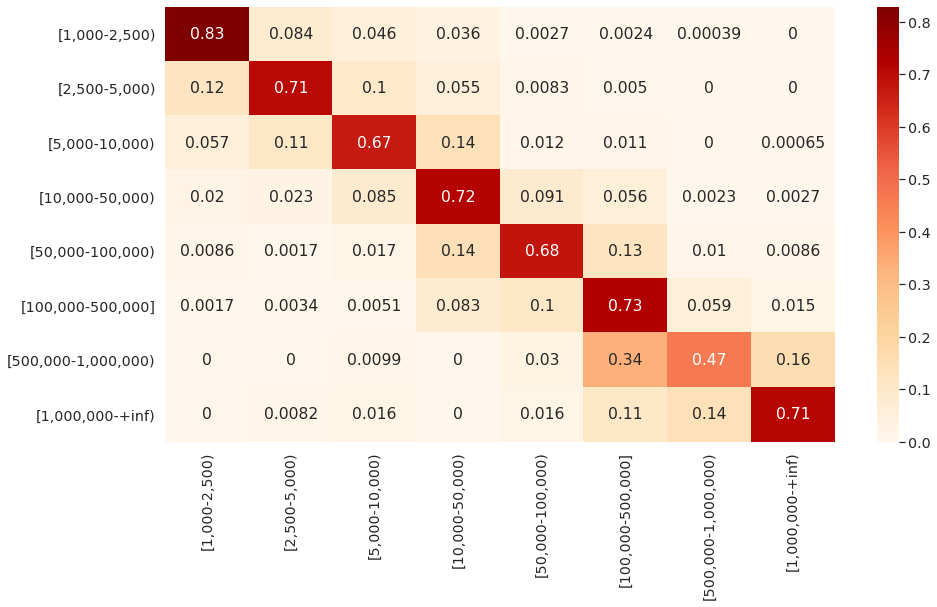

In [3]:
model = StackingClassifier(
            estimators=[
               ('modified_huber_SGD', SGDClassifier(loss="modified_huber", alpha=0.002, penalty="l2", max_iter=10000)),
               ('LogisticRegression', LogisticRegression(max_iter=10000, C=0.1, class_weight='balanced'))
            ],
            final_estimator=LogisticRegression(max_iter=10000, C=0.1, class_weight='balanced'))

stem_vectorizer = CountVectorizer(analyzer=words_analyser, min_df=3)
tfidf_transf = TfidfTransformer()
word_count_vector = stem_vectorizer.fit_transform(train_all.description)
tfidf_vector = tfidf_transf.fit_transform(word_count_vector)

X_train, y_train = get_upsampling(train_all, count_threshold=10000, tfidf_vector=tfidf_vector)

model.fit(X_train, y_train)
x_test_transformed = tfidf_transf.transform(stem_vectorizer.transform(test_X.description))
stacking_pred = model.predict(x_test_transformed)
evaluate(stacking_pred, test_y)

### Even though I use a very simple approach, I got an acceptable Quadratic Kappa and F1 scores which will be usefull to improve even more the regression model (see [Regression evaluation notebook](../evaluation.ipynb) )

### Let's see the worst errors. 
* <b>I think we could improve our results with a better punctuation treatment (instead of remove everything at once)</b>
* <b> We could also generate tokens for similar (and very importan) words like: Census, population and inhabitants)
* <b> We might also try embeddings </b>

In [5]:
from IPython.display import Markdown
error_analyser = test_y.rename('target').astype(int).to_frame()
error_analyser['description'] = test_X.description
error_analyser['prediction'] = stacking_pred
error_analyser['abs_diff'] = (error_analyser.target - error_analyser.prediction).abs()
worst_errors = error_analyser[error_analyser.abs_diff > 0].sort_values('abs_diff', ascending=False)
for description in worst_errors.description.head(10).values:
    display(Markdown('<b>Real description: </b>' + description))
    display(Markdown('<b>Generated tokens: </b>' + ', '.join(words_analyser(description))))
    print('-'*80)
    

<b>Real description: </b>"Parsons is the county seat and largest city in Tucker County, West Virginia, United States. The population was 1,485 at the 2010 census. The mayor of Parsons is Dorothy Judy and the city administrator is Jason Myers. The city is also governed by a city council."@en

<b>Generated tokens: </b>parson, counti, seat, largest, citi, tucker, counti, west, virginia, unit, state, popul, possible_d, possible_d, census, mayor, parson, dorothi, judi, citi, administr, jason, myer, citi, also, govern, citi, council, parson counti, counti seat, seat largest, largest citi, citi tucker, tucker counti, counti west, west virginia, virginia unit, unit state, state popul, popul possible_d, possible_d possible_d, possible_d census, census mayor, mayor parson, parson dorothi, dorothi judi, judi citi, citi administr, administr jason, jason myer, myer citi, citi also, also govern, govern citi, citi council

--------------------------------------------------------------------------------


<b>Real description: </b>"Sükösd (Croatian: Čikuzda) is a village in Bács-Kiskun county, in the Southern Great Plain region of southern Hungary."@en

<b>Generated tokens: </b>sükösd, croatian, čikuzda, villag, bácskiskun, counti, southern, great, plain, region, southern, hungari, sükösd croatian, croatian čikuzda, čikuzda villag, villag bácskiskun, bácskiskun counti, counti southern, southern great, great plain, plain region, region southern, southern hungari

--------------------------------------------------------------------------------


<b>Real description: </b>"Kallstadt (German pronunciation: [ˈkalʃtat]) is a village in the Palatine part of Rhineland-Palatinate, one of Germany's 16 federal states. It is part of the Rhine-Neckar Metropolitan Region whose largest city is Mannheim, Germany's 22nd largest city. During much of the 19th century, it was part of the Kingdom of Bavaria. It has gained international media attention as the ancestral home of the related Heinz and Trump families, two prominent business and political families in the United States."@en

<b>Generated tokens: </b>kallstadt, german, pronunci, ˈkalʃtat, villag, palatin, part, rhinelandpalatin, one, germani, feder, state, part, rhineneckar, metropolitan, region, whose, largest, citi, mannheim, germani, 22nd, largest, citi, much, 19th, centuri, part, kingdom, bavaria, gain, intern, media, attent, ancestr, home, relat, heinz, trump, famili, two, promin, busi, polit, famili, unit, state, kallstadt german, german pronunci, pronunci ˈkalʃtat, ˈkalʃtat villag, villag palatin, palatin part, part rhinelandpalatin, rhinelandpalatin one, one germani, germani feder, feder state, state part, part rhineneckar, rhineneckar metropolitan, metropolitan region, region whose, whose largest, largest citi, citi mannheim, mannheim germani, germani 22nd, 22nd largest, largest citi, citi much, much 19th, 19th centuri, centuri part, part kingdom, kingdom bavaria, bavaria gain, gain intern, intern media, media attent, attent ancestr, ancestr home, home relat, relat heinz, heinz trump, trump famili, famili two, two promin, promin busi, busi polit, polit famili, famili unit, unit state

--------------------------------------------------------------------------------


<b>Real description: </b>"Tuba City (Navajo: Tó Naneesdizí) is an unincorporated town in Coconino County, Arizona, on Navajo lands, in the United States. It is the second-largest community in Coconino County. The population of the census-designated place (CDP) was 8,611 at the 2010 census. It is the Navajo Nation's largest community, slightly larger than Shiprock, New Mexico, and the headquarters of the Western Navajo Agency. The Hopi village of Moenkopi lies directly to its southeast."@en

<b>Generated tokens: </b>tuba, citi, navajo, tó, naneesdizí, unincorpor, town, coconino, counti, arizona, navajo, land, unit, state, secondlargest, communiti, coconino, counti, popul, censusdesign, place, cdp, <10,000, possible_d, census, navajo, nation, largest, communiti, slight, larger, shiprock, new, mexico, headquart, western, navajo, agenc, hopi, villag, moenkopi, lie, direct, southeast, tuba citi, citi navajo, navajo tó, tó naneesdizí, naneesdizí unincorpor, unincorpor town, town coconino, coconino counti, counti arizona, arizona navajo, navajo land, land unit, unit state, state secondlargest, secondlargest communiti, communiti coconino, coconino counti, counti popul, popul censusdesign, censusdesign place, place cdp, cdp <10,000, <10,000 possible_d, possible_d census, census navajo, navajo nation, nation largest, largest communiti, communiti slight, slight larger, larger shiprock, shiprock new, new mexico, mexico headquart, headquart western, western navajo, navajo agenc, agenc hopi, hopi villag, villag moenkopi, moenkopi lie, lie direct, direct southeast

--------------------------------------------------------------------------------


<b>Real description: </b>"Ploiești (UK: , US: , Romanian: [ploˈjeʃtʲ]), formerly spelled Ploești, is a city and county seat in Prahova County,Romania. Part of the historical region of Muntenia, it is located 56 km (35 mi) north of Bucharest. The area of the city is around 60 km2. It borders the Blejoi village in the north, Bărcănești and Brazi villages in the south, Târgșoru Vechi in the west and Bucov village in the east. Ploiești has direct access to the Prahova Valley, one of the most important alpine tourism areas in Romania."@en

<b>Generated tokens: </b>ploiești, uk, us, romanian, ploˈjeʃtʲ, former, spell, ploești, citi, counti, seat, prahova, countyromania, part, histor, region, muntenia, locat, km, mi, north, bucharest, area, citi, around, km2, border, blejoi, villag, north, bărcănești, brazi, villag, south, târgșoru, vechi, west, bucov, villag, east, ploiești, direct, access, prahova, valley, one, import, alpin, tourism, area, romania, ploiești uk, uk us, us romanian, romanian ploˈjeʃtʲ, ploˈjeʃtʲ former, former spell, spell ploești, ploești citi, citi counti, counti seat, seat prahova, prahova countyromania, countyromania part, part histor, histor region, region muntenia, muntenia locat, locat km, km mi, mi north, north bucharest, bucharest area, area citi, citi around, around km2, km2 border, border blejoi, blejoi villag, villag north, north bărcănești, bărcănești brazi, brazi villag, villag south, south târgșoru, târgșoru vechi, vechi west, west bucov, bucov villag, villag east, east ploiești, ploiești direct, direct access, access prahova, prahova valley, valley one, one import, import alpin, alpin tourism, tourism area, area romania

--------------------------------------------------------------------------------


<b>Real description: </b>"Domburg is a seaside resort on the North Sea, on the northwest coast of Walcheren in the Dutch province of Zeeland. It is a part of the municipality of Veere, and lies about 11 km northwest of the city of Middelburg, the provincial capital."@en

<b>Generated tokens: </b>domburg, seasid, resort, north, sea, northwest, coast, walcheren, dutch, provinc, zeeland, part, municip, veer, lie, km, northwest, citi, middelburg, provinci, capit, domburg seasid, seasid resort, resort north, north sea, sea northwest, northwest coast, coast walcheren, walcheren dutch, dutch provinc, provinc zeeland, zeeland part, part municip, municip veer, veer lie, lie km, km northwest, northwest citi, citi middelburg, middelburg provinci, provinci capit

--------------------------------------------------------------------------------


<b>Real description: </b>"Ciudad Cuauhtémoc is a town in the extreme southern Mexican state of Chiapas. It is part of the municipality of Frontera Comalapa and is situated on the Guatemala-Mexico border opposite the city of La Mesilla, Huehuetenango, Guatemala. As of 2010, Ciudad Cuauhtémoc had a population of 2,325. The city's name was changed from El Ocotal to Ciudad Cuauhtémoc on November 18, 1943, and serves as Mexico's southern terminus of the Pan-American Highway."@en

<b>Generated tokens: </b>ciudad, cuauhtémoc, town, extrem, southern, mexican, state, chiapa, part, municip, frontera, comalapa, situat, guatemalamexico, border, opposit, citi, la, mesilla, huehuetenango, guatemala, possible_d, ciudad, cuauhtémoc, popul, <2,500, citi, name, chang, el, ocot, ciudad, cuauhtémoc, novemb, possible_d, serv, mexico, southern, terminus, panamerican, highway, ciudad cuauhtémoc, cuauhtémoc town, town extrem, extrem southern, southern mexican, mexican state, state chiapa, chiapa part, part municip, municip frontera, frontera comalapa, comalapa situat, situat guatemalamexico, guatemalamexico border, border opposit, opposit citi, citi la, la mesilla, mesilla huehuetenango, huehuetenango guatemala, guatemala possible_d, possible_d ciudad, ciudad cuauhtémoc, cuauhtémoc popul, popul <2,500, <2,500 citi, citi name, name chang, chang el, el ocot, ocot ciudad, ciudad cuauhtémoc, cuauhtémoc novemb, novemb possible_d, possible_d serv, serv mexico, mexico southern, southern terminus, terminus panamerican, panamerican highway

--------------------------------------------------------------------------------


<b>Real description: </b>"The city of Adel is the county seat of Cook County, Georgia, United States, located fifty-two miles (84 km) southeast of Albany. As of the 2010 census, the city had a population of 5,344."@en

<b>Generated tokens: </b>citi, adel, counti, seat, cook, counti, georgia, unit, state, locat, fiftytwo, mile, km, southeast, albani, possible_d, census, citi, popul, <10,000, citi adel, adel counti, counti seat, seat cook, cook counti, counti georgia, georgia unit, unit state, state locat, locat fiftytwo, fiftytwo mile, mile km, km southeast, southeast albani, albani possible_d, possible_d census, census citi, citi popul, popul <10,000

--------------------------------------------------------------------------------


<b>Real description: </b>"Ceguaca (Spanish pronunciation: [seˈɣwaka]) is a municipality in the Honduran department of Santa Bárbara. Their latitude is 14.80000 and their longitude is -88.20000."@en

<b>Generated tokens: </b>ceguaca, spanish, pronunci, seˈɣwaka, municip, honduran, depart, santa, bárbara, latitud, +1,000,000, longitud, +1,000,000, ceguaca spanish, spanish pronunci, pronunci seˈɣwaka, seˈɣwaka municip, municip honduran, honduran depart, depart santa, santa bárbara, bárbara latitud, latitud +1,000,000, +1,000,000 longitud, longitud +1,000,000

--------------------------------------------------------------------------------


<b>Real description: </b>"Kesälahti (Swedish: Kesälahti, also Kesälax) is a former municipality of Finland. It was consolidated with Kitee on 1 January 2013. It is located in the province of Eastern Finland and is part of the North Karelia region. The municipality has a population of 2,326(31 December 2012) and covers an area of 583.08 square kilometres (225.13 sq mi) ofwhich 195.19 km2 (75.36 sq mi)is water. The population density is5.9965/km2 (15.531/sq mi)."@en

<b>Generated tokens: </b>kesälahti, swedish, kesälahti, also, kesälax, former, municip, finland, consolid, kite, januari, possible_d, locat, provinc, eastern, finland, part, north, karelia, region, municip, popul, <500,000, decemb, possible_d, cover, area, <100,000, squar, kilometr, <50,000, sq, mi, ofwhich, <50,000, km2, <10,000, sq, mii, water, popul, densiti, is59965km2, 15531sq, mi, kesälahti swedish, swedish kesälahti, kesälahti also, also kesälax, kesälax former, former municip, municip finland, finland consolid, consolid kite, kite januari, januari possible_d, possible_d locat, locat provinc, provinc eastern, eastern finland, finland part, part north, north karelia, karelia region, region municip, municip popul, popul <500,000, <500,000 decemb, decemb possible_d, possible_d cover, cover area, area <100,000, <100,000 squar, squar kilometr, kilometr <50,000, <50,000 sq, sq mi, mi ofwhich, ofwhich <50,000, <50,000 km2, km2 <10,000, <10,000 sq, sq mii, mii water, water popul, popul densiti, densiti is59965km2, is59965km2 15531sq, 15531sq mi

--------------------------------------------------------------------------------
